In [1]:
#following along with CNN - Codealong
#for create new folders and move the new files in there
import os, shutil

In [2]:
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import warnings
warnings.filterwarnings('ignore')


In [3]:
def data_aug():
    dataAug = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 45,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    return dataAug

In [4]:
# get all the data in the directory xray/test (624 images), and reshape them
test_generator = ImageDataGenerator(rescale= 1./255).flow_from_directory("Data/chest_xray/chest_xray/test/",
                                                                         batch_size = 624)

# get all the data in the directory xray/val (16 images), and reshape them
val_generator = ImageDataGenerator(1./255).flow_from_directory("Data/chest_xray/chest_xray/val/",
                                                               batch_size = 16)

# get all the data in the directory xray/train (5216 images), and reshape them
train_generator =ImageDataGenerator(1./255).flow_from_directory("Data/chest_xray/chest_xray/train/",
                                              batch_size = 5216)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [5]:
train_images, train_labels = next(train_generator)

test_images, test_labels = next(test_generator)

val_images, val_labels = next(val_generator)

In [6]:
len(train_labels)

5216

In [7]:
data_aug = data_aug()
data_aug.fit(train_images)

In [8]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 256, 256, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 256, 256, 3)
test_labels shape: (624, 2)
val_images shape: (16, 256, 256, 3)
val_labels shape: (16, 2)


In [9]:
len(train_images)

5216

In [10]:
#reshaping data
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 196608)
(624, 196608)
(16, 196608)


In [11]:
#reshaping label
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

In [39]:
train_img.shape

(5216, 196608)

In [12]:
train_labels

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [13]:
import pandas as pd
import seaborn as sns
def class_inbalance(train_labels):

    mask = []
    for i in train_labels:
        if(i[1] == 1):
            mask.append("Pneumonia")
        else:
            mask.append("Normal")
    print(pd.DataFrame(mask).value_counts(normalize=True))

    sns.set_style('darkgrid')
    return sns.countplot(mask)

Pneumonia    0.742906
Normal       0.257094
dtype: float64


<AxesSubplot:ylabel='count'>

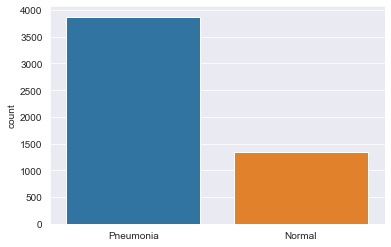

In [14]:
class_inbalance(train_labels)

In [15]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 42)

In [16]:
lr.fit(train_img, train_y)

LogisticRegression(random_state=42)

In [17]:
lr.score(test_img,test_y)

0.7483974358974359

In [20]:
# recall_score(lr, test_img, test_y)

TypeError: Expected sequence or array-like, got <class 'sklearn.linear_model._logistic.LogisticRegression'>

In [19]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix, plot_roc_curve, \
make_scorer, recall_score, precision_score, f1_score

In [21]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(criterion = "entropy", max_depth = 15,
                          min_samples_split= 5, n_estimators= 700,
                          max_features = 'log2', random_state = 42)

In [22]:
rf.fit(train_img, train_y)

RandomForestClassifier(criterion='entropy', max_depth=15, max_features='log2',
                       min_samples_split=5, n_estimators=700, random_state=42)

In [23]:
from sklearn.model_selection import cross_val_score
cross_val_score(rf, test_img, test_y, cv = 5)

array([0.928     , 0.88      , 0.904     , 0.872     , 0.87096774])

In [24]:
print(f'Test score of random forest model: {rf.score(test_img, test_y)}')

Test score of random forest model: 0.625


In [25]:
#baseline model
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(196608,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                3932180   
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 3,932,373
Trainable params: 3,932,373
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='sgd',
             loss = 'binary_crossentropy',
             metrics =  ['accuracy'])

histoire = model.fit(train_img,
                    train_y,
                    epochs = 50,
                    batch_size = 32,
                    validation_data=(val_img,val_y))

Epoch 1/50
163/163 [==============================] - 2s 14ms/step - loss: 166897008640.0000 - accuracy: 0.7343 - val_loss: 0.7056 - val_accuracy: 0.5000
Epoch 2/50
163/163 [==============================] - 2s 14ms/step - loss: 0.6116 - accuracy: 0.7429 - val_loss: 0.7290 - val_accuracy: 0.5000
Epoch 3/50
163/163 [==============================] - 2s 14ms/step - loss: 0.5902 - accuracy: 0.7429 - val_loss: 0.7517 - val_accuracy: 0.5000
Epoch 4/50
163/163 [==============================] - 2s 14ms/step - loss: 0.5801 - accuracy: 0.7429 - val_loss: 0.7704 - val_accuracy: 0.5000
Epoch 5/50
163/163 [==============================] - 2s 14ms/step - loss: 0.5751 - accuracy: 0.7429 - val_loss: 0.7853 - val_accuracy: 0.5000
Epoch 6/50
163/163 [==============================] - 2s 14ms/step - loss: 0.5726 - accuracy: 0.7429 - val_loss: 0.7964 - val_accuracy: 0.5000
Epoch 7/50
163/163 [==============================] - 2s 14ms/step - loss: 0.5714 - accuracy: 0.7429 - val_loss: 0.8046 - val_accur

In [27]:
results_train = model.evaluate(train_img, train_y)

163/163 [==============================] - 1s 8ms/step - loss: 0.5700 - accuracy: 0.7429


In [28]:
results_test = model.evaluate(test_img,test_y)

20/20 [==============================] - 0s 6ms/step - loss: 0.6954 - accuracy: 0.6250


In [29]:
results_train

[0.5699955224990845, 0.7429064512252808]

In [30]:
results_test

[0.6953539848327637, 0.625]

In [35]:

from keras import regularizers

# CNN build
np.random.seed(123)
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                       input_shape = (256,256,3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 124, 32)      16416     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)            

In [36]:
history = model.fit(train_images,
                    train_y,
                    steps_per_epoch= 20,
                    epochs=20,
                    batch_size=16,
                    validation_data=(val_images, val_y))
print(f"Training Score of first convolution neural network: {model.evaluate(train_images, train_y)}")
print(f"Test Score of first convolution neural network: {model.evaluate(test_images, test_y)}")

Epoch 1/20
20/20 [==============================] - 9s 431ms/step - loss: nan - accuracy: 0.6969 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/20
20/20 [==============================] - 8s 424ms/step - loss: nan - accuracy: 0.7094 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/20
20/20 [==============================] - 8s 423ms/step - loss: nan - accuracy: 0.7375 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/20
20/20 [==============================] - 9s 455ms/step - loss: nan - accuracy: 0.7250 - val_loss: nan - val_accuracy: 0.5000
Epoch 5/20
20/20 [==============================] - 9s 433ms/step - loss: nan - accuracy: 0.7437 - val_loss: nan - val_accuracy: 0.5000
Epoch 6/20
20/20 [==============================] - 9s 434ms/step - loss: nan - accuracy: 0.7688 - val_loss: nan - val_accuracy: 0.5000
Epoch 7/20
12/20 [=================>............] - ETA: 3s - loss: nan - accuracy: 0.7552

KeyboardInterrupt: 

In [ ]:
model.summary()

In [ ]:
from keras.models import Sequential
model = models.Sequential()
model = Sequential()
model.add(layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(layers.Dropout(0.1))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(layers.Flatten())
model.add(layers.Dense(units = 128 , activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])


model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

history = model.fit(train_img,
                    train_y,
                    steps_per_epoch=50,
                    epochs=20,
                    batch_size=8,
                    validation_data=(val_images, val_y))



print(f"\nTraining Score: {model.evaluate(train_img, train_y)}")
print(f"\nTest Score: {model.evaluate(test_img, test_y)}")

In [ ]:
model.summary()

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.summary()

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy',])  

history = model.fit(train_img, 
                    train_y,  
                    epochs=20, 
                    validation_data = (val_images, val_y))

In [ ]:
import os
import tqdm
from os import walk

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt